In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy

import vice

import arya
import surp
from surp._globals import AGB_MODELS
from surp import yields
from surp.gce_math import Z_SUN, MH_to_Z, Z_to_MH, calc_y

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from singlezone import run_singlezone

In [4]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 3.00e-02 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [5]:
Z_max = 0.02
Z_min = 0.0001
AGB_LABELS = ["C11", "V13", "K16",  "P16"]

hmap = arya.figure.colorbar.HueMap((Z_to_MH(Z_min),Z_to_MH(Z_max)))


def plot_yield_table(study = "cristallo11", hmap=hmap, ele="c", fmt="o", 
                     ax=None, fig=None, factor=1, **kwargs):
    """
    Plots the yield table in VICE (without modification) for each metallic
    """
    
    if ax is None:
        ax = plt.gca()

    yields, masses, Zs = vice.yields.agb.grid(ele, study=study)
    N = len(Zs)

    for i in range(N):
        y = np.array(yields)[:,i] * factor
        Z = Zs[i]
        c = hmap(Z_to_MH(Z))
        f = ax.plot(masses, y, fmt, label=f"Z = {Z}", c=c, **kwargs)
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

In [6]:
def plot_yields(study = "cristallo11", masses=np.linspace(0.08, 8.01, 1000), Zs=None, ele="c", 
                ax=None, fig=None, hmap=hmap, factor=1, **kwargs):
    """
    Plots the yields (calculated using surp.agb_interpolator) for each metallicity given.
    """
    
    if ax is None:
        fig, ax = plt.subplots()

    if Zs is None:
        _yields, _masses, Zs = vice.yields.agb.grid(ele, study=study)
    
    ya = surp.agb_interpolator.interpolator(ele, study=study, no_negative=True)

    for i in range(len(Zs)):
        Z = Zs[i] 
        c = hmap(Z_to_MH(Z))
        y = [ya(m, Z)*factor for m in masses]
        f = ax.plot(masses, y, label=f"Z = {Z}", c=c, **kwargs)

    return f

In [7]:
AGB_MODELS, AGB_LABELS

(['cristallo11', 'ventura13', 'karakas16', 'pignatari16'],
 ['C11', 'V13', 'K16', 'P16'])

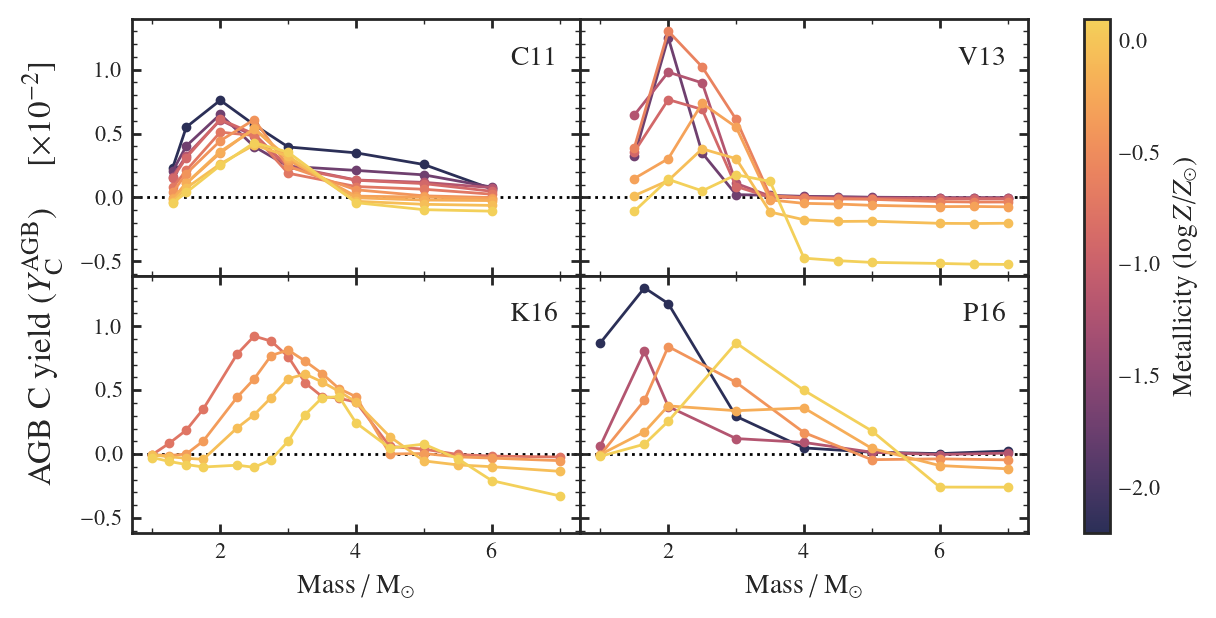

In [8]:
SCALE_FACTOR=1e2
fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_yield_table(study, ax=ax, fig=fig, fmt="o-", factor=SCALE_FACTOR)
    
    # plot label
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    


arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity ($\log Z/Z_\odot$)")

plt.setp(axs[-1, :], xlabel=r'Mass / ${\rm M}_\odot$')
fig.supylabel(r"AGB C yield ($Y_{\rm C}^{\rm AGB}$) $\quad [\times 10^{-2}]$")

plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("figures/agb_yields.pdf")

The AGB figure of the paper

In [9]:
agb_interpolator = surp.agb_interpolator.interpolator
def plot_y_z(Zs, ele="c", kind="agb", fmt="-", factor = 1, **kwargs):
    y_c_agb = calc_y(Zs, ele=ele, kind=kind) * factor
    return plt.plot(Z_to_MH(Zs), y_c_agb, fmt, **kwargs), y_c_agb

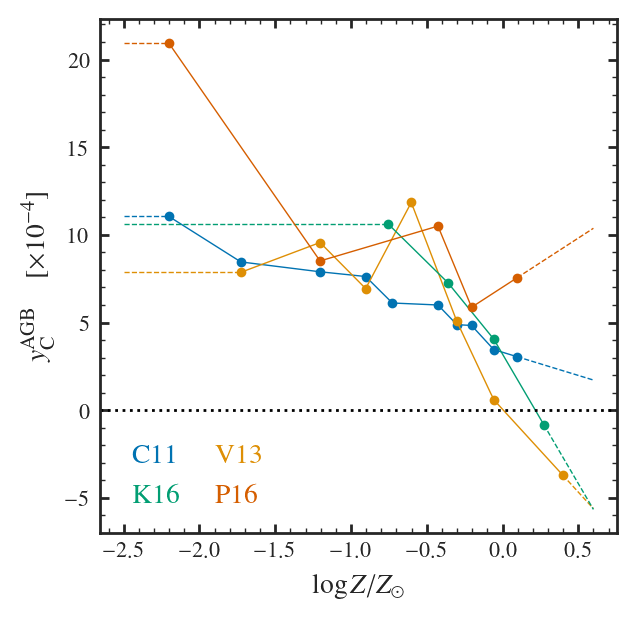

In [10]:
x_min = -2.5
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

for i in range(4):
    model = AGB_MODELS[i]

    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    kwargs = dict(fmt="o", zorder=i, factor=scale, color=arya.COLORS[i])
    
    # plots importaint points
    _y1, _m1, Zs = vice.yields.agb.grid('c', study=model)
    (line,), _x = plot_y_z(Zs, **kwargs)
    
    # plot solid within range
    MoverH_min = Z_to_MH(min(Zs))
    MoverH_max = Z_to_MH(max(Zs))
    
    kwargs["fmt"] = "-"
    kwargs["lw"] = 0.5
    Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))
    plot_y_z(Zs, label=AGB_LABELS[i], **kwargs)

    # dashed extrapolation
    kwargs["fmt"] = "--"
    Zs = MH_to_Z(np.linspace(x_min, MoverH_min, N_points))    
    plot_y_z(Zs, **kwargs)
    Zs = MH_to_Z(np.linspace(MoverH_max, x_max, N_points))
    plot_y_z(Zs, **kwargs)


plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-4}]$")


arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)

plt.savefig("figures/y_agb_vs_z.pdf")

In [11]:
def plot_ssp_time(ele="c", Z=surp.Z_SUN, t_end=10, color=None, **kwargs):
    m_c, times = vice.single_stellar_population(ele, Z=surp.Z_SUN, dt=0.01, time=t_end)
    y = np.array(m_c)/m_c[-1]    
    
    plt.plot(times, y, color=color, **kwargs)
    
    # plot 50% time
    f = scipy.interpolate.interp1d(y, times)

    plt.scatter(f(0.5), 0.5, color=color)
        
    print(f"t1/2 = {f(0.5):0.2f}")
    
    return times, y

t1/2 = 0.80
cristallo11
ymin = -0.19
ymax = 1.01 

t1/2 = 2.25
ventura13
ymin = -45.89
ymax = 1.00 

t1/2 = 0.36
karakas16
ymin = -0.24
ymax = 1.12 

t1/2 = 0.50
pignatari16
ymin = -0.12
ymax = 1.00 

t1/2 = 0.96


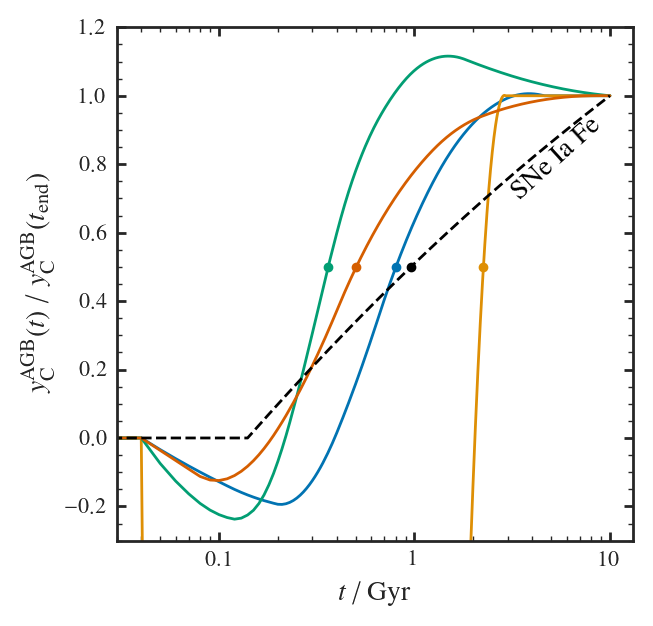

In [12]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    times, y = plot_ssp_time()
    
    print(model)
    print(f"ymin = {np.min(y):0.2f}")
    print(f"ymax = {np.max(y):0.2f} \n")

    
plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")


plot_ssp_time("fe", color="k", ls="--")


plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")
plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("figures/y_agb_vs_t.pdf")

In [16]:
from scipy.interpolate import CubicSpline
y1, m1, z1 = vice.yields.agb.grid("c")

In [ ]:
for i in range(len(z1)):
    
    def m_model(m):
        cs = CubicSpline([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1) & (m < 7))
        
    x = np.linspace(1.3, 6, 1000)
    y =m_model(x)
    plt.plot(x, y)
    plt.scatter(m1, [a[i] for a in y1])

In [ ]:
from scipy.integrate import quad
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import curve_fit

In [ ]:
y_c_agb1 = []
for i in range(len(z1)):
    def m_model(m):
        cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1.3) & (m < 6))
    norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
    yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
    y_c_agb1.append(yc)

In [ ]:
mh1 = np.log10(np.array(z1)/0.014)

cs = CubicSpline(mh1, y_c_agb1)

plt.scatter(mh1, y_c_agb1)

def yc_agb(z):
    return cs(z)
x = np.linspace(-2.2, 0.2, 1000)

def lin(x, a, b):
    return a*x + b

popt, covt = curve_fit(lin, mh1, y_c_agb1)
plt.plot(x, yc_agb(x))
plt.plot(x, lin(x, *popt))
plt.ylim(0)
print(popt)
print(np.diag(covt)**0.5)





vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0
Zs = 0.014*10**np.linspace(-2, 1, 100)
model = "cristallo11"
    
    # plots importaint points
y1, m1, z1 = vice.yields.agb.grid('c', study=model)
Zs = np.array(z1)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
        
y_c_agb = np.array(mass_yields)/1e6 
y_o_cc = 0.015
plt.scatter(np.log10(Zs/0.014), y_c_agb, zorder=4-i)
    
    
MoverH_min = np.log10(min(Zs)/0.014)
MoverH_max = np.log10(max(Zs)/0.014)
    
Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

l, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
              zorder=4-i, color="red")

Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.get_color(),  zorder=4-i)

Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.get_color(), zorder=4-i)

# Extra

In [ ]:
for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    plot_yields(study)
    plt.xlabel(r'Mass / ${\rm M}_\odot$')
    plt.ylabel(r"AGB C yield ($\times 10^{-2}$)")
    plt.title(label)
    plt.show()


In [ ]:
Zs = MH_to_Z(np.arange(-2.5, 0.8, 0.2))
for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    plot_yields(study, Zs=Zs)
    plt.xlabel(r'Mass / ${\rm M}_\odot$')
    plt.ylabel(r"AGB C yield ($\times 10^{-2}$)")
    plt.title(label)
    plt.show()

In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=surp.Z_SUN, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    plt.plot(times, y)
    
    f = scipy.interpolate.interp1d(y, times)
    plt.scatter(f(0.5), 0.5)
    

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")

m_fe, times = vice.single_stellar_population("fe", Z=surp.Z_SUN)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times, y, 
         linestyle="--", zorder=-1, color="k")
f = scipy.interpolate.interp1d(y, times)
plt.scatter(f(0.5), 0.5, color="k")

vice.yields.ccsne.settings["n"] = 0
m_fe, times = vice.single_stellar_population("n", Z=surp.Z_SUN)
y = np.array(m_fe)/m_fe[-1]

#plt.plot(times, y, 
#         linestyle="--", zorder=-1, color="k")
f = scipy.interpolate.interp1d(y, times)
#plt.scatter(f(0.5), 0.5, color="k")


plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y(t)\;/\;y({10\, \rm Gyr})$")
plt.xscale("log")
plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])


In [ ]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    dt = times[1] - times[0]
    plt.plot(times[:-1], (y[1:] - y[:-1])/dt)
        

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt, 
         linestyle="--", zorder=-1, color="k")



plt.xlabel(r"$t$ (Gyr)")
plt.ylabel(r"$y(t)\;/\;y(t_{\rm end})$")
plt.xscale("log")
plt.xlim(0.03, 13.2)
plt.ylim(0, 4)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
x = np.array(times)

t_d = 0.15
τa = 0.3
plt.plot(times, (x > t_d) * (x-t_d)/τa**2* np.exp(-(x-t_d)/τa), color="k")

vice.yields.agb.settings["c"] = a_agb
m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
y = np.array(m_c)/m_c[-1]
dt = times[1] - times[0]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt)


In [ ]:
surp.yields.set_yields(mass_factor=1.5)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 5)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

In [ ]:
surp.yields.set_yields(c_agb_model="karakas16", c_agb_kwargs={"mass_factor": 1.5})
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

In [ ]:
Zs = 0.016*np.logspace(-2, 0.5)
surp.yields.set_yields(c_agb_kwargs={"mass_factor": 1})
vice.yields.ccsne.settings["c"] = 0
plot_y_z(Zs)


surp.yields.set_yields(c_agb_kwargs={"mass_factor": 1.5})
vice.yields.ccsne.settings["c"] = 0
plot_y_z(Zs)

In [ ]:
surp.yields.set_yields(agb_model="ventura13", mass_factor=1.5, no_negative=True)
y_agb = vice.yields.agb.settings["c"]

for Z in MH_to_Z(np.linspace(-3, 0.5, 10)):
    N = 100
    Ms = np.linspace(1, 7, N)
    ys = np.zeros(N)
    
    for i in range(N):
        ys[i] = y_agb(Ms[i], Z)
    
    plt.plot(Ms, ys, color=hmap(Z_to_MH(Z)))

In [ ]:

def plot_n_table(study = "cristallo11", ax=None, fig=None, factor=1e2, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('n', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i] * factor
        z = z1[i] 
        c = hmap(np.log10(z/0.014))
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

In [ ]:
plot_n_table("pignatari16")
arya.Colorbar(huemap=hmap, label=r"Metallicity ($\log Z/Z_\odot$)")
plt.xlabel("M/Msun")
plt.ylabel("$y_{\rm N}$ --- Ritter et al. 2018")

In [ ]:
hm

In [ ]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])


for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        plt.plot(times, np.array(m_c)/1e6, color=hmap(np.log10(z/0.014)))



    arya.Colorbar(huemap=mpp)
    plt.show()

In [ ]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)

    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        plt.plot(times, np.array(m_c)/m_c[-1], color=ma(np.log10(z/0.014)))



    arya.Colorbar(huemap=mpp)
    plt.show()

In [ ]:
yields.set_defaults()

plot_y_z(MH_to_Z(np.linspace(-2, 1)), "n", label="linear");

vice.yields.agb.settings["n"] = "pignatari16"

plot_y_z(MH_to_Z(np.linspace(-2, 1)), "n", label="ritter+18");
plt.xlabel("[M/H]")
plt.ylabel("y_N")

plt.legend()
plt.savefig("figures/_y_n_z.pdf")

In [ ]:
plot_c_table("pignatari16", "n")
plt.xlabel("Mzams")
plt.ylabel(r"$y_N \times 10^2$")
#arya.Colorbar(huemap=hmap, label=r"Metallicity ($\log Z/Z_\odot$)")
plt.savefig("figures/_ritter18_n_table.pdf")

## Testing the oob settings

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.48e-03 + 1.47e-03 [M/H] or   1.00 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



t1/2 = 0.80
t1/2 = 0.80
yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb  

(0.03, 13.2)

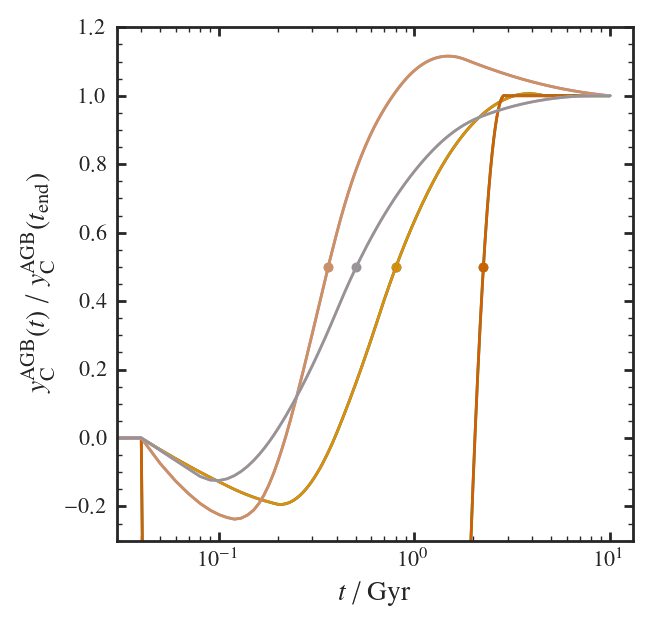

In [21]:
plt.figure(figsize=(10/3, 10/3))



for i in range(4):
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    times, y = plot_ssp_time()
    
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=AGB_MODELS[i])
    times, y = plot_ssp_time()



plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")

plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)

As expected, the surp yield settings exactly reproduce what the interpolator uses

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.48e-03 + 1.47e-03 [M/H] or   1.00 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

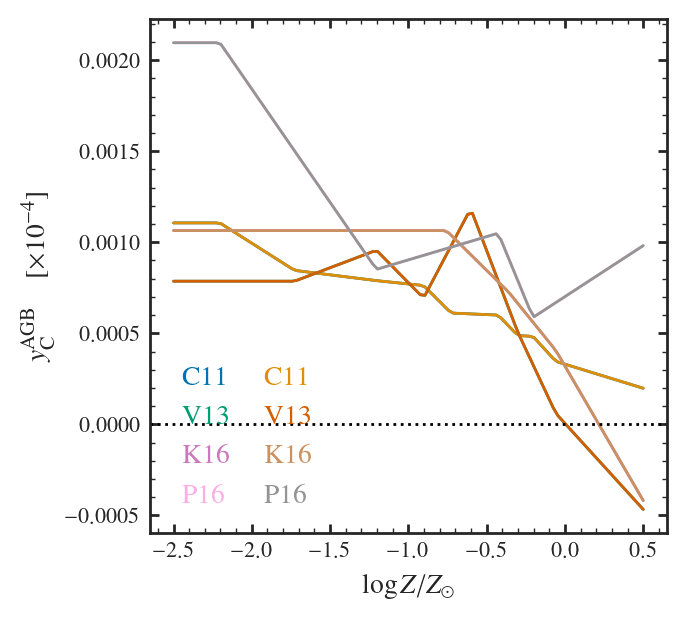

In [22]:
x_min = -2.5
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

MoverH_min = -2.5
MoverH_max = 0.5
Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")
    
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-4}]$")


arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)